In [ ]:
### Get time to target, percent correct of CO targets that would intersect the obstacle;
### Jeev --> 

In [3]:
#reload(util_fcns)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import analysis_config, tables
from online_analysis import util_fcns
import seaborn
seaborn.set(font='Arial',context='talk',font_scale=1.5, style='white')

in task
in task
in task


In [3]:
%matplotlib notebook

In [15]:
### Get percent correct, t2t; 
def get_pc_t2t(te=analysis_config.data_params['grom_input_type']):

    fall, axall = plt.subplots(figsize=(3, 4))
    fall_t2t, axall_t2t = plt.subplots(figsize=(3, 4))
    fall_viol, axall_viol = plt.subplots(figsize=(3, 4))
    
    pref = analysis_config.config['grom_pref']

    ### Open up CO / OBS ###
    co_obs_dict = pickle.load(open(pref+'co_obs_file_dict.pkl'))

    co = []
    obs = []
    
    co_violate_obs = []
    co_violate_obs_mn = []
    
    co_t2t = []
    obs_t2t = []
    
    co_t2t_mn = [];
    obs_t2t_mn = []; 
    
    for i_d, day in enumerate(te):
        
        for i_t, tsk in enumerate(day):
            day_tsk_rew = []; 
            day_tsk_non = []; 
            tsk_t2t = []; 
            
            if i_t == 0:
                day_co_violate = []
            
            for i_te, tei in enumerate(tsk):

                ######################
                ### Get HDF file #####
                ######################
                hdf = co_obs_dict[tei, 'hdf']
                hdfix = hdf.rfind('/')
                hdf = tables.openFile(pref+hdf[hdfix:])

                ##########################
                ### Get rew ix; ##########
                ##########################
                rew_ix = np.array([t[1] for it, t in enumerate(hdf.root.task_msgs[:]) if t[0]=='reward'])
                
                ##########################
                #### Get time to target ##
                ##########################
                go_ix  = np.array([hdf.root.task_msgs[it-3][1] for it, t in enumerate(hdf.root.task_msgs[:]) if np.logical_and(t[0] == 'reward', t[1] in rew_ix)])
                t2t = (rew_ix - go_ix)*1/60. # Samples --> Sec 
                tsk_t2t.append(t2t)
                
                assert(len(t2t) == len(rew_ix))
                
                #########################################
                ##### Get each trials' position traj ####
                #########################################
                if i_t == 0: 
                    for i_trl, (g, r) in enumerate(zip(go_ix, rew_ix)):
                        pos_traj = hdf.root.task[g:r]['cursor'][:, [0, 2]]
                        targ_pos = hdf.root.task[g+12]['target'][[0, 2]]
                        
                        assert(np.linalg.norm(targ_pos) > 0)
                        obs_pos = targ_pos/2.
                        
                        perc_abide = np.array([1., 1.])
                        for o, obs_width in enumerate([1., 1.5]):
                            ### Does pos_traj go through this path? 
                            x_pos_traj_inside = np.abs(pos_traj[:, 0] - obs_pos[0]) < obs_width
                            y_pos_traj_inside = np.abs(pos_traj[:, 1] - obs_pos[1]) < obs_width
                            pos_inside = np.logical_and(x_pos_traj_inside, y_pos_traj_inside)
                        
                            if np.any(pos_inside):
                                perc_abide[o] = 0; 
                        
                        day_co_violate.append(np.sum(perc_abide) / float(len(perc_abide)))
                            
                ##########################
                #### Extract Errors ######
                ##########################
                hold_ix = []; time_ix = []; obs_ix = []; 
                for _, (msg, tm) in enumerate(hdf.root.task_msgs[:]):
                    if msg == 'hold_penalty':
                        hold_ix.append(tm)
                    elif msg == 'timeout_penalty':
                        time_ix.append(tm)
                    elif msg == 'obstacle_penalty':
                        obs_ix.append(tm)

                ########################
                #### Plot Errors #######
                ######################## 
                f, ax = plt.subplots()
                ax.vlines(rew_ix, 0, 2, 'b')
                day_tsk_rew.append(rew_ix)
                
                if len(hold_ix) > 0:
                    ax.vlines(np.hstack((hold_ix)), 0, 1, 'r')
                    day_tsk_non.append(np.hstack((hold_ix)))
                    
                if len(time_ix) > 0:
                    ax.vlines(np.hstack((time_ix)), 0, 1, 'm')
                    day_tsk_non.append(np.hstack((time_ix)))
                    
                if len(obs_ix) > 0:
                    ax.vlines(np.hstack((obs_ix)), 0, 1, 'g')
                    day_tsk_non.append(np.hstack((obs_ix)))
                    
                ax.set_title('Day %d, Tsk %d, Sess %d' %(i_d, i_t, i_te))
                
            #### Plot the percent correct ####
            tot = len(np.hstack((day_tsk_non))) + len(np.hstack((day_tsk_rew)))
            pc = float(len(np.hstack((day_tsk_rew)))) / float(tot)
            #axall.plot(i_d + 0.5*i_t, pc, 'k.')
            
            ### Plot as box plot; 
            if i_t == 0:
                co.append(pc)
                co_t2t.append(np.hstack((tsk_t2t)))
                co_t2t_mn.append(np.mean(np.hstack((tsk_t2t))))
                
                #### Day CO violate #####
                N = float(len(np.hstack((day_tsk_rew))))
                #Nviol = float(len(np.hstack((day_co_violate))))
                #co_violate_obs.append((N - Nviol)/N)
                co_violate_obs.append(np.mean(np.hstack((day_co_violate))))
                    
            elif i_t == 1:
                obs.append(pc) 
                obs_t2t.append(np.hstack((tsk_t2t)))
                obs_t2t_mn.append(np.mean(np.hstack((tsk_t2t))))
                
    ######################################
    ###### Percent Correct box plot ######
    ######################################
    util_fcns.draw_plot(0, co, 'g', [1., 1., 1., 0.], axall, width = .5,)
    util_fcns.draw_plot(1, obs,'b', [1., 1., 1., 0.], axall, width = .5)
    
    for d, (c, o) in enumerate(zip(co, obs)):
        axall.plot([0, 1], [c, o], '-', color='gray', linewidth=.5)
    
    axall.set_xticks([0, 1])
    axall.set_xticklabels(['CO', 'OBS'], rotation=45)
    axall.set_ylabel('Percent Correct')
    
    axall.set_xlim([-0.8, 1.8])
    axall.set_ylim([0, 1.])

    ######################################
    ###### T2T Correct box plot ######
    ######################################
    util_fcns.draw_plot(0, np.hstack((co_t2t)), 'k', [1., 1., 1., 0.], axall_t2t, width = .5,)
    util_fcns.draw_plot(1, np.hstack((obs_t2t)),'k', [1., 1., 1., 0.], axall_t2t, width = .5)
    
    for d, (c, o) in enumerate(zip(co_t2t_mn, obs_t2t_mn)):
        axall_t2t.plot([0, 1], [c, o], '-', color='gray', linewidth=.5)
    
    axall_t2t.set_xticks([0, 1])
    axall_t2t.set_xticklabels(['CO', 'OBS'], rotation=45)
    axall_t2t.set_ylabel('Time to Target (sec)')
    
    axall_t2t.set_xlim([-0.8, 1.8])
    axall_t2t.set_ylim([0, 7.5])
    fall_t2t.tight_layout()
    util_fcns.savefig(fall_t2t, 't2t_grom')

    ###########################
    ###### % not violate ######
    ###########################
    util_fcns.draw_plot(0, np.hstack((co_violate_obs)), 'g', [1., 1., 1., 0.], axall_viol, width=0.5)
    axall_viol.plot(np.zeros(len(co_violate_obs)), co_violate_obs, '.', color='gray')
    axall_viol.set_xticks([0])
    axall_viol.set_xticklabels(['CO'], rotation=45)
    axall_viol.set_ylabel('Average Percent of Cases \nCO trial abides OBS criteria')
    axall_viol.set_ylim([0., 1.])


<IPython.core.display.Javascript object>


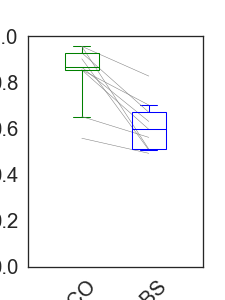

<IPython.core.display.Javascript object>


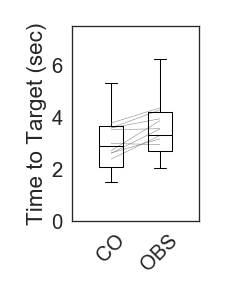

<IPython.core.display.Javascript object>


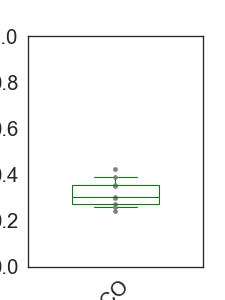

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:42: DeprecationWarning: openFile() is pending deprecation, use open_file() instead. You may use the pt2to3 tool to update your source code.


<IPython.core.display.Javascript object>


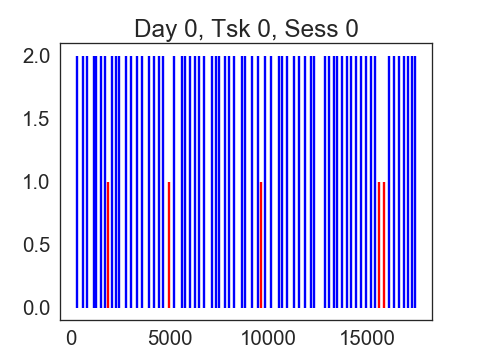

<IPython.core.display.Javascript object>


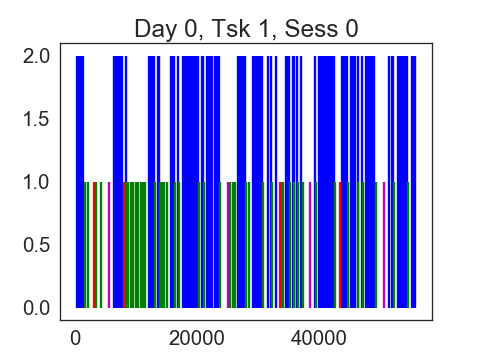

<IPython.core.display.Javascript object>


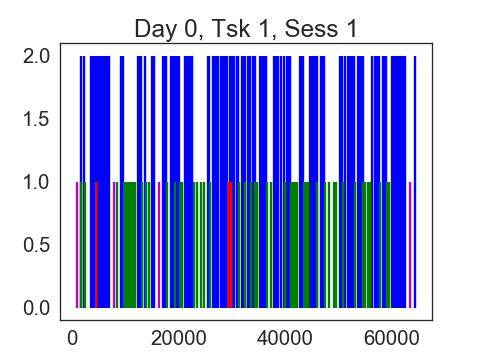

<IPython.core.display.Javascript object>


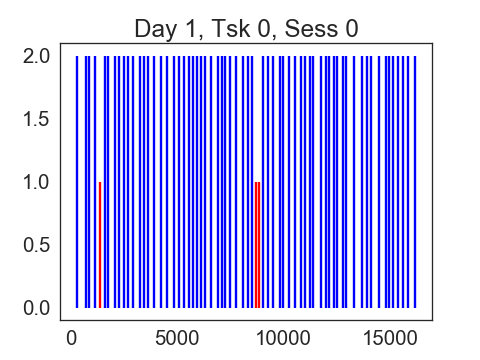

<IPython.core.display.Javascript object>


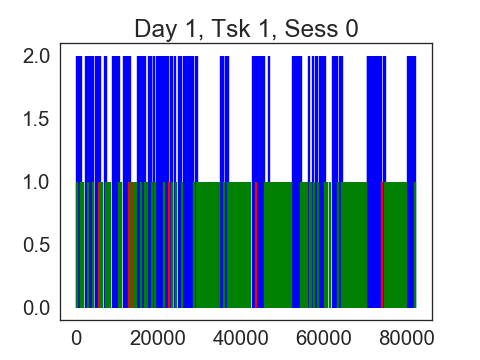

<IPython.core.display.Javascript object>


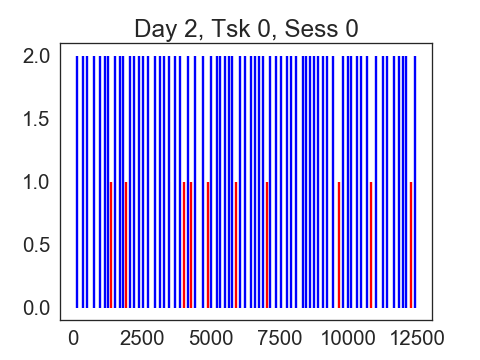

<IPython.core.display.Javascript object>


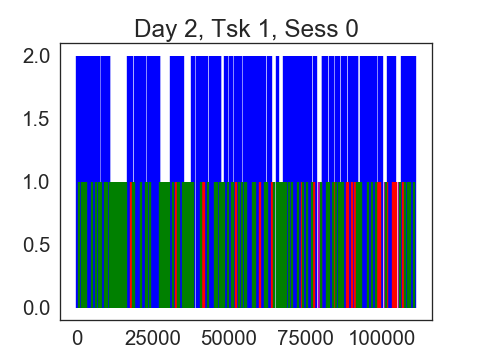

<IPython.core.display.Javascript object>


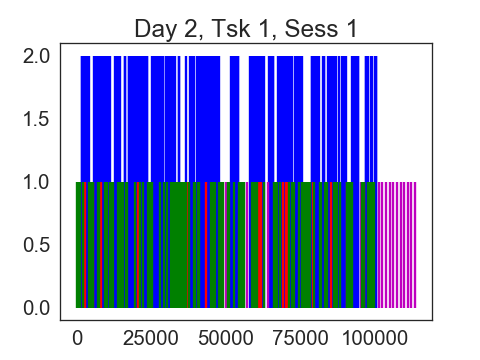

<IPython.core.display.Javascript object>


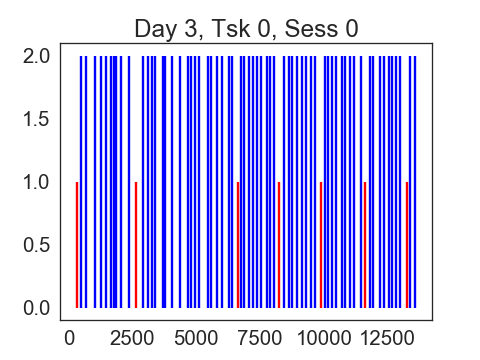

<IPython.core.display.Javascript object>


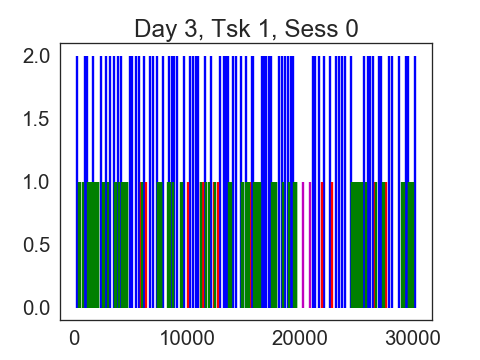

<IPython.core.display.Javascript object>


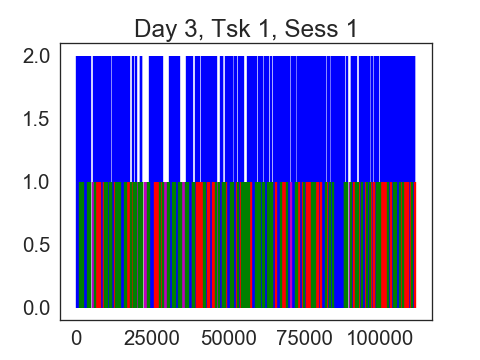

<IPython.core.display.Javascript object>


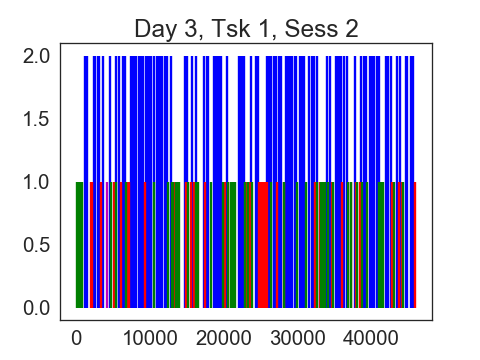

<IPython.core.display.Javascript object>


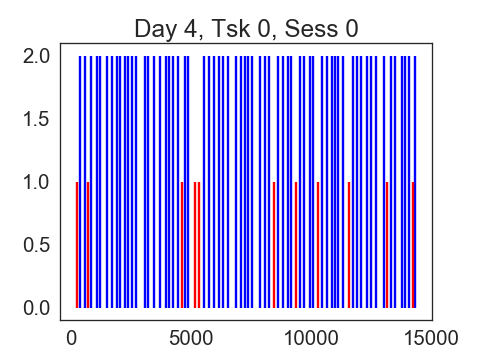

<IPython.core.display.Javascript object>


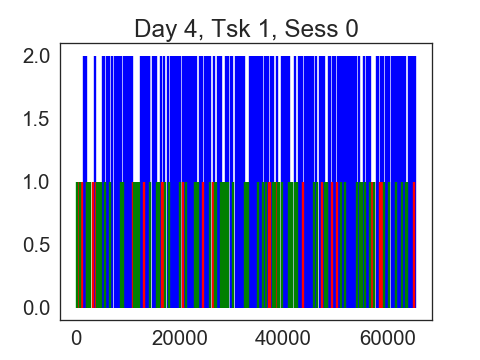

<IPython.core.display.Javascript object>


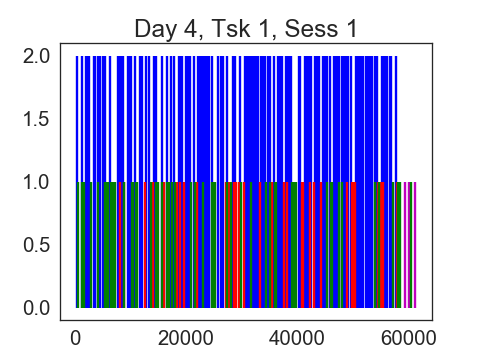

<IPython.core.display.Javascript object>


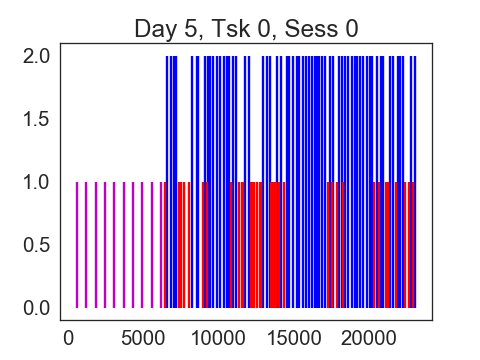

<IPython.core.display.Javascript object>


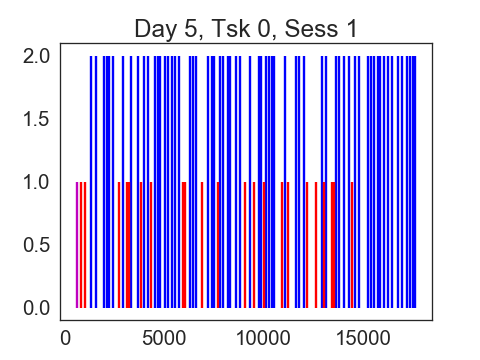

<IPython.core.display.Javascript object>


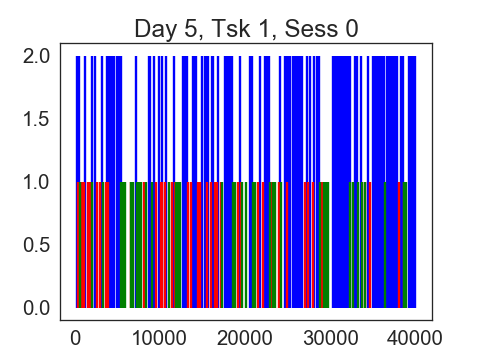

<IPython.core.display.Javascript object>


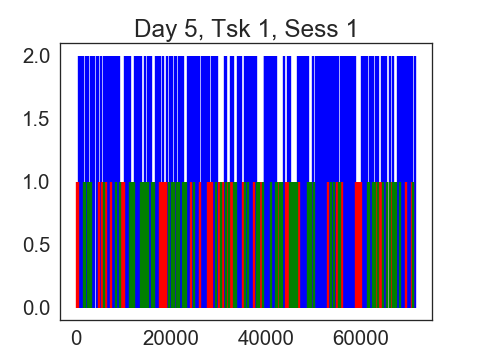

<IPython.core.display.Javascript object>


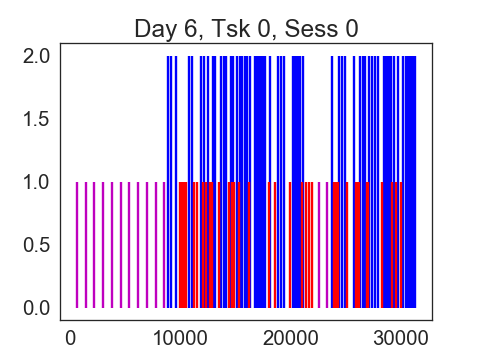

<IPython.core.display.Javascript object>


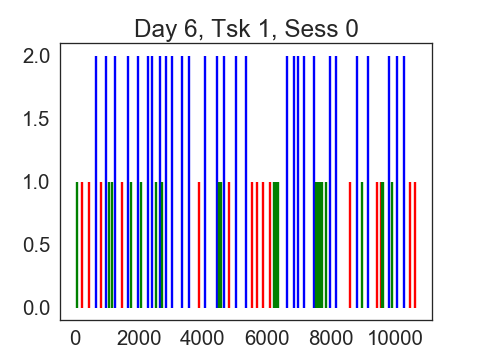

<IPython.core.display.Javascript object>


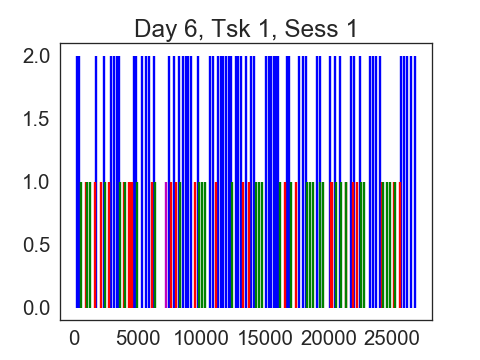

<IPython.core.display.Javascript object>


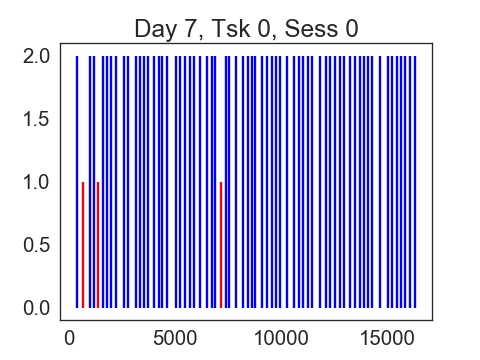

<IPython.core.display.Javascript object>


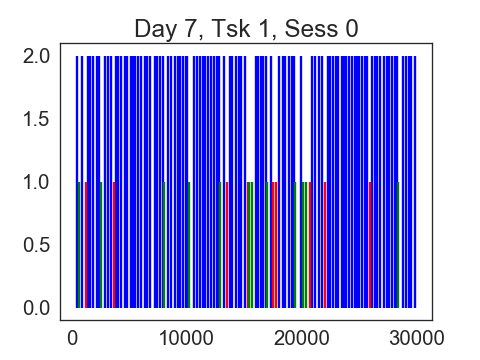

<IPython.core.display.Javascript object>


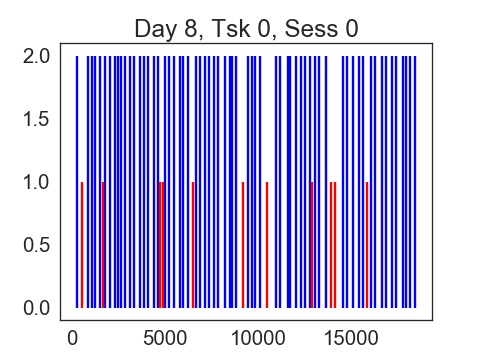

<IPython.core.display.Javascript object>


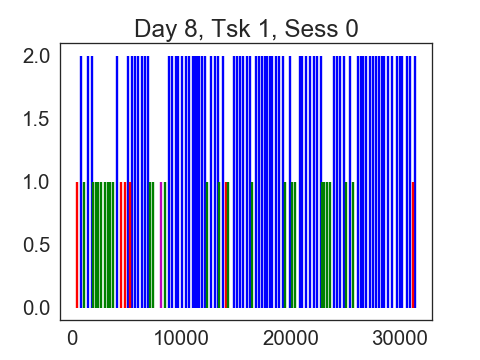

In [16]:
get_pc_t2t()

In [5]:
####### Jeevs ######
from resim_ppf import ppf_pa

In [6]:
ppf_pa

<module 'resim_ppf.ppf_pa' from 'resim_ppf/ppf_pa.pyc'>

Bin Curson kin Size 20
152 (39, 7)


<IPython.core.display.Javascript object>


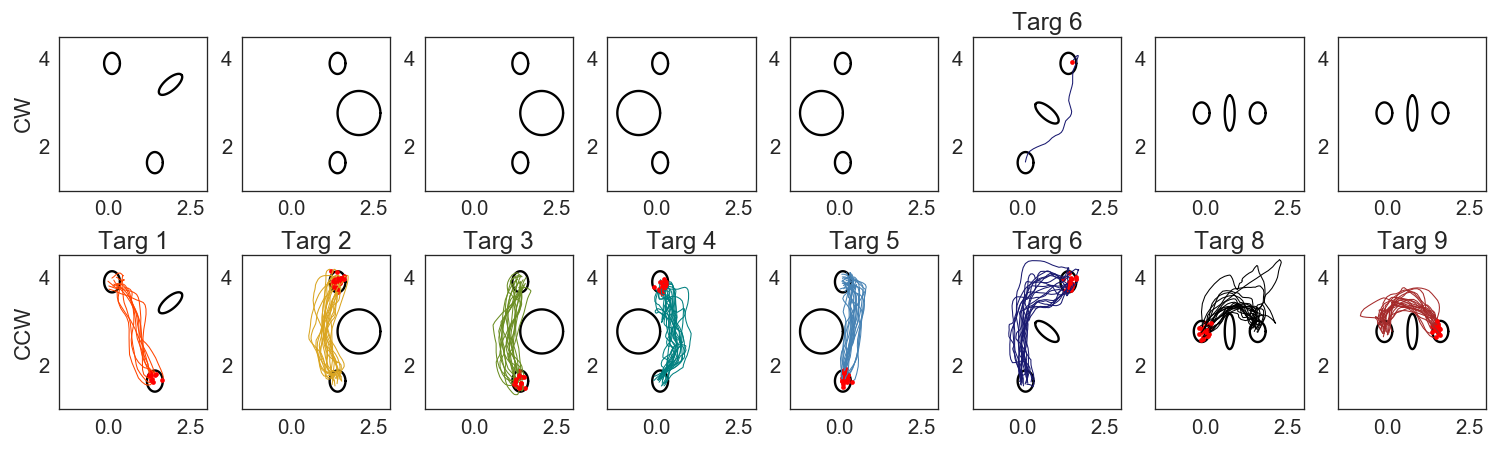

In [7]:
reload(ppf_pa)
for day in [1]:
    ppf_pa.plot_jeev_trials(targ_only=None, day_ix=day, binsize=0.1)
    #ppf_pa.plot_jeev_trials(task='co', targ_only=None, day_ix=day, binsize=0.1)

<IPython.core.display.Javascript object>


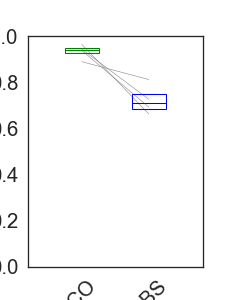

<IPython.core.display.Javascript object>


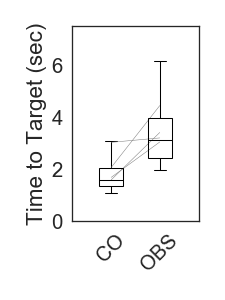

<IPython.core.display.Javascript object>


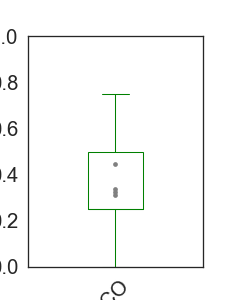

1. Total Go Ix: 212
2. Go Ix, out of center: 211
3. Go Ix, rm targs obs only: 211
1. Total Go Ix: 232
2. Go Ix, out of center: 232
3. Go Ix, rm targs obs only: 220
Day 0, Task 1, Discrepancy 1
1. Total Go Ix: 18
2. Go Ix, out of center: 18
3. Go Ix, rm targs obs only: 18
1. Total Go Ix: 187
2. Go Ix, out of center: 187
3. Go Ix, rm targs obs only: 176
Day 1, Task 1, Discrepancy 1
1. Total Go Ix: 96
2. Go Ix, out of center: 96
3. Go Ix, rm targs obs only: 96
1. Total Go Ix: 192
2. Go Ix, out of center: 192
3. Go Ix, rm targs obs only: 185
1. Total Go Ix: 83
2. Go Ix, out of center: 83
3. Go Ix, rm targs obs only: 83
1. Total Go Ix: 150
2. Go Ix, out of center: 150
3. Go Ix, rm targs obs only: 145
mean perc correct CO 0.93, OBS 0.72


In [17]:
reload(ppf_pa)
# ppf_pa.plot_percent_correct_t2t(plot=False)
ppf_pa.plot_percent_correct_t2t(plot=False, min_obs_targ = 2)

In [160]:
#### Test obstacles ####
x = sio.loadmat('resim_ppf/jeev_obs_positions_from_amy.mat')

from resim_ppf import file_key
targ_list = file_key.obstrialList

In [214]:
100*16/3600.

0.4444444444444444

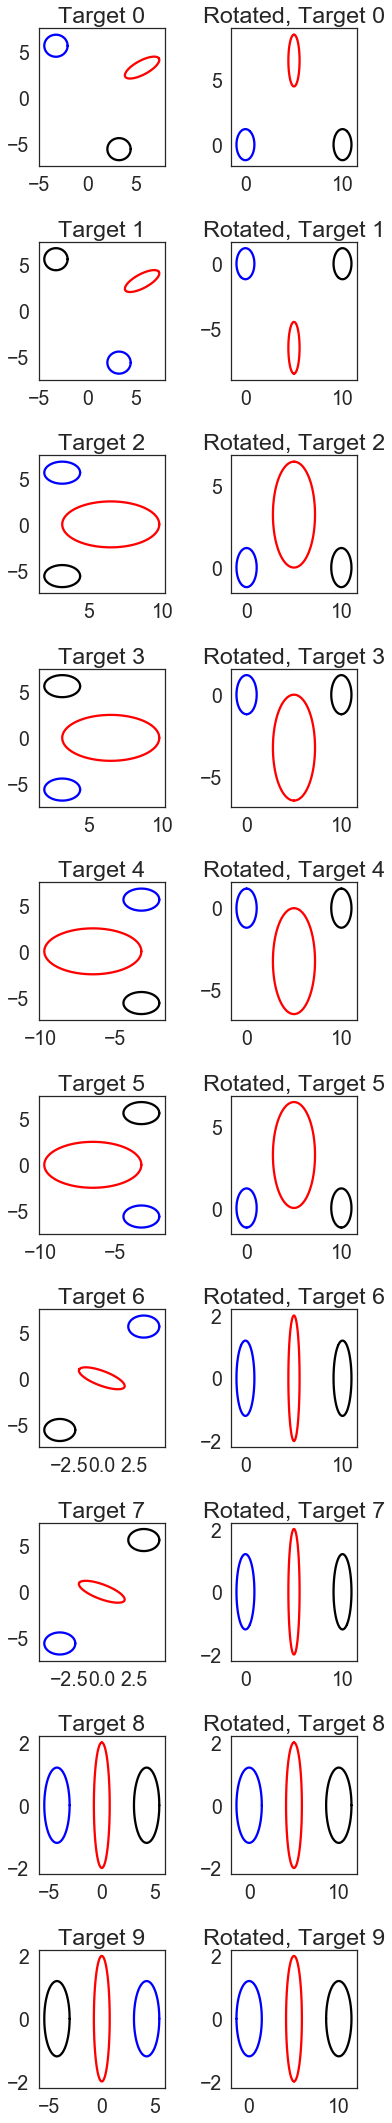

In [217]:
#### Rotate all the targets into place ######
f, ax = plt.subplots(nrows = 10, ncols = 2, figsize=(6, 30))
for i in range(targ_list.shape[0]):
    
    targ_series = targ_list[i, :] - 63
    
    TC0 = np.mean(x['targObjects'][:, :, int(targ_series[0])-1], axis=1)
    TC2 = np.mean(x['targObjects'][:, :, int(targ_series[2])-1], axis=1) - TC0
    
    ### Center by TC0
    ### Rotate by TC2; 
    ### What is the angle with respect to center point; 
    TC2_norm = TC2 / np.linalg.norm(TC2)
    angle = np.arctan2(TC2_norm[1], TC2_norm[0])
    R = np.array([[np.cos(-1*angle), -np.sin(-1*angle)], [np.sin(-1*angle), np.cos(-1*angle)]])
    
    ### Scaling on x-axis ###
    TC2_rot = np.dot(R, TC2[:, np.newaxis])
    scale_x = 10./TC2_rot[0]
    
    for i_t, targ in enumerate(targ_series):
        T = x['targObjects'][:, :, int(targ)-1] # 2 x 100 
        T_dem = T-TC0[:, np.newaxis]
        T_rot = np.dot(R, T_dem)
        
        if i_t == 0:
            ax[i, 1].plot(T_rot[0, :]*scale_x, T_rot[1, :], 'b-')
            ax[i, 0].plot(T[0, :], T[1, :], 'b-')
            
        elif i_t == 1:
            ax[i, 1].plot(T_rot[0, :]*scale_x, T_rot[1, :], 'r-')
            ax[i, 0].plot(T[0, :], T[1, :], 'r-')
        elif i_t == 2:
            ax[i, 1].plot(T_rot[0, :]*scale_x, T_rot[1, :], 'k-')
            ax[i, 0].plot(T[0, :], T[1, :], 'k-')
    ax[i, 0].set_title('Target %d' %(i))
    ax[i, 1].set_title('Rotated, Target %d' %(i))
    f.tight_layout()
    

In [179]:
centerPos = np.array([ 0.0377292,  0.1383867])
targetPos = np.array([[ 0.1027292 ,  0.1383867 ],
			         [ 0.08369114,  0.18434864],
			         [ 0.0377292 ,  0.2033867 ],
			         [-0.00823274,  0.18434864],
			         [-0.0272708 ,  0.1383867 ],
			         [-0.00823274,  0.09242476],
			         [ 0.0377292 ,  0.0733867 ],
			         [ 0.08369114,  0.09242476]])

In [182]:
np.linalg.norm(targetPos - centerPos[np.newaxis, :], axis=1)

array([0.065, 0.065, 0.065, 0.065, 0.065, 0.065, 0.065, 0.065])

In [ ]:
(x-h)^2/a^2 + (y-k)^2/b^2 <= 1

In [3]:
from online_analysis import plot_fr_diffs

Import Error in db.namelist: from tasklist import tasks -- likely error in a single task preventing import
error importing BMI configuration variables


Traceback (most recent call last):
  File "/Users/preeyakhanna/bmi3d/db/namelist.py", line 92, in <module>
    from bmilist import *
  File "/Users/preeyakhanna/bmi3d/config_files/bmilist.py", line 25, in <module>
    from ismore.ismore_bmi_lib import StateSpaceArmAssist, StateSpaceReHand, StateSpaceIsMore
ImportError: No module named ismore.ismore_bmi_lib
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pybasicbayes-0.2.4-py2.7-macosx-10.9-x86_64.egg/pybasicbayes/util/stats.py:11: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2020-10-21 11:22:09.210025. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)

